In [1]:
# read csv file and print out the data
import csv
import sys
import os
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
datapath = '../data/2011-2012 Solar home electricity data v2.csv'
# skip the first line in csv and read the next line as column
# then read the rest of the file and store as dataframe
df = pl.read_csv(datapath, skip_rows=1)
print(df)
print(df.columns)

shape: (270_304, 54)
┌──────────┬───────────┬──────────┬──────────────────────┬───┬───────┬───────┬───────┬─────────────┐
│ Customer ┆ Generator ┆ Postcode ┆ Consumption Category ┆ … ┆ 23:00 ┆ 23:30 ┆ 0:00  ┆ Row Quality │
│ ---      ┆ Capacity  ┆ ---      ┆ ---                  ┆   ┆ ---   ┆ ---   ┆ ---   ┆ ---         │
│ i64      ┆ ---       ┆ i64      ┆ str                  ┆   ┆ f64   ┆ f64   ┆ f64   ┆ str         │
│          ┆ f64       ┆          ┆                      ┆   ┆       ┆       ┆       ┆             │
╞══════════╪═══════════╪══════════╪══════════════════════╪═══╪═══════╪═══════╪═══════╪═════════════╡
│ 1        ┆ 3.78      ┆ 2076     ┆ CL                   ┆ … ┆ 0.0   ┆ 0.0   ┆ 1.063 ┆ null        │
│ 1        ┆ 3.78      ┆ 2076     ┆ GC                   ┆ … ┆ 0.118 ┆ 0.219 ┆ 0.162 ┆ null        │
│ 1        ┆ 3.78      ┆ 2076     ┆ GG                   ┆ … ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ null        │
│ 1        ┆ 3.78      ┆ 2076     ┆ CL                   ┆ … ┆ 0.0   ┆

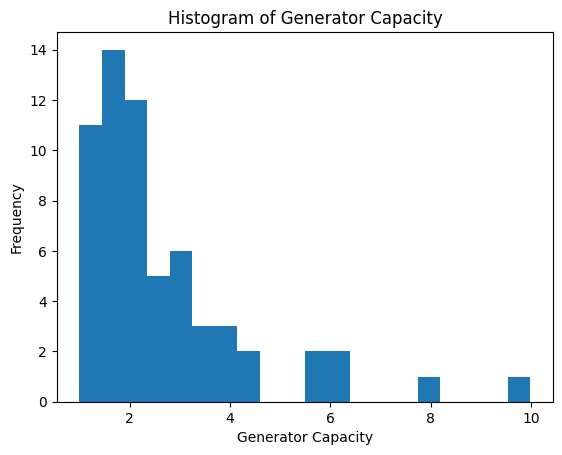

In [3]:
# show me different values in 'Generator Capacity'
GenCap = df['Generator Capacity'].unique()

# plot histogram of 'Generator Capacity'
plt.hist(GenCap, bins=20)
plt.xlabel('Generator Capacity')
plt.ylabel('Frequency')
plt.title('Histogram of Generator Capacity')
plt.show()


In [3]:
from helper import transform_polars_df

# get all the unique customers as their own dataframes
customers = df['Customer'].unique()
# pick 80% of the random customers as training data
training_customers = np.random.choice(customers, int(0.8*len(customers)), replace=False)
# the rest of the customers are testing data
testing_customers = np.setdiff1d(customers, training_customers)

In [5]:
# loop through each customer and use transform_polars_df to get the dataframe and store it in a list call dataset
training_dataset = []
for customer in training_customers:
    customer_df = df.filter(pl.col('Customer') == customer)
    try:
        newcustomerdf = transform_polars_df(customer_df, import_energy_price=0.15, export_energy_price=0.1, price_periods="7am – 10am | 4pm – 9pm", default_import_energy_price=0.1, default_export_energy_price=0.08)
    except Exception as e:
        print(f"Error with customer as training dataset: {customer}")
        print(e)
        break
    training_dataset.append(newcustomerdf)

testing_dataset = []
for customer in testing_customers:
    customer_df = df.filter(pl.col('Customer') == customer)
    try:
        newcustomerdf = transform_polars_df(customer_df, import_energy_price=0.15, export_energy_price=0.1, price_periods="7am – 10am | 4pm – 9pm", default_import_energy_price=0.1, default_export_energy_price=0.08)
    except Exception as e:
        print(f"Error with customer as testing dataset: {customer}")
        print(e)
        break
    testing_dataset.append(newcustomerdf)


In [10]:
len(training_dataset)


0

In [11]:
import gymnasium as gym
from stable_baselines3 import PPO, A2C, DDPG
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_checker import check_env
from EnergySimEnv import SolarBatteryEnv


# Helper: create an environment instance from a dataset.
def make_env(dataset):
    def _init():
        env = SolarBatteryEnv(dataset, max_step=len(dataset)-1)
        return env
    return _init

# Create a list of environment creation functions to build a vectorized environment.
env_fns = [make_env(ds) for ds in training_dataset]
vec_env = DummyVecEnv(env_fns)

num_total_steps = len(training_dataset[0])*len(training_dataset)
print(f"Total number of steps possible in training dataset: {num_total_steps}")

testing_env_fns = [make_env(ds) for ds in testing_dataset]


Total number of steps possible in training dataset: 4216080


/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [ ]:
evaluation_results = {}

# Train first agent with PPO
ppo_model = PPO("MlpPolicy", vec_env, verbose=1, device='cpu')
mean_reward, std_reward = evaluate_policy(ppo_model, Monitor(testing_env_fns[0]()), n_eval_episodes=5, deterministic=False)
evaluation_results['PPO_pre_training'] = {'mean_reward': mean_reward, 'std_reward': std_reward}
ppo_model.learn(total_timesteps=num_total_steps)
mean_reward, std_reward = evaluate_policy(ppo_model, Monitor(testing_env_fns[0]()), n_eval_episodes=5, deterministic=False)
evaluation_results['PPO_post_training'] = {'mean_reward': mean_reward, 'std_reward': std_reward}
ppo_model.save("ppo_agent")

# Train second agent with A2C
a2c_model = A2C("MlpPolicy", vec_env, verbose=1, device='cpu')
mean_reward, std_reward = evaluate_policy(a2c_model, Monitor(testing_env_fns[0]()), n_eval_episodes=5, deterministic=False)
evaluation_results['A2C_pre_training'] = {'mean_reward': mean_reward, 'std_reward': std_reward}
a2c_model.learn(total_timesteps=num_total_steps)
mean_reward, std_reward = evaluate_policy(a2c_model, Monitor(testing_env_fns[0]()), n_eval_episodes=5, deterministic=False)
evaluation_results['A2C_post_training'] = {'mean_reward': mean_reward, 'std_reward': std_reward}
a2c_model.save("a2c_agent")

# Train third agent with DDPG
ddpg_model = DDPG("MlpPolicy", vec_env, verbose=1)
mean_reward, std_reward = evaluate_policy(ddpg_model, Monitor(testing_env_fns[0]()), n_eval_episodes=5, deterministic=False)
evaluation_results['DDPG_pre_training'] = {'mean_reward': mean_reward, 'std_reward': std_reward}
ddpg_model.learn(total_timesteps=num_total_steps)
mean_reward, std_reward = evaluate_policy(ddpg_model, Monitor(env_fns[0]()), n_eval_episodes=5, deterministic=False)
evaluation_results['DDPG_post_training'] = {'mean_reward': mean_reward, 'std_reward': std_reward}
ddpg_model.save("ddpg_agent")

print(evaluation_results)



Using cpu device
-------------------------------
| time/              |        |
|    fps             | 22598  |
|    iterations      | 1      |
|    time_elapsed    | 21     |
|    total_timesteps | 491520 |
-------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 5080      |
|    iterations           | 2         |
|    time_elapsed         | 193       |
|    total_timesteps      | 983040    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.42     |
|    explained_variance   | 0         |
|    learning_rate        | 0.0003    |
|    loss                 | 7.48e+30  |
|    n_updates            | 10        |
|    policy_gradient_loss | -3.26e-10 |
|    std                  | 1         |
|    value_loss           | 4.25e+31  |
---------------------------------------